## NYT API: Example with Electric Vehicles for GM and Tesla 

In [71]:
from __future__ import division
import pandas
from matplotlib import pyplot as plt 
import requests
import urllib.parse
import json
import math
import time
import csv
from textblob import TextBlob
# to install, use: conda install -c conda-forge textblob 
%matplotlib inline

## This is background info on the NYTimes API for the audience

>#### (from NYTimes API FAQ, https://developer.nytimes.com/faq) the Article Search API is rate limited to 1,000 calls per day, and 1 call per second. If you need a higher rate limit, please contact us at code@nytimes.com.

>#### we'll be using the NYTimes article_search API; this searches NYTimes artiles from Sept 18, 1851 to today, retrieving headlines, abstracts, lead paragraphs, links to associated multimedia and other articl..

### The article_search API has the following parameters (not all need to be used):

> ##### _q_ - Search query term. Search is performed on the article body, headline and byline

> ##### _fq_ - "Filtered search query using standard Lucene syntax. The filter query can be specified with or without a limiting field: label. See Filtering Your Search for more information about filtering."

> ##### _begin_date_ - "Format: YYYYMMDD Restricts responses to results with publication dates of the date specified or later."

> ##### _end_date_ - "Format: YYYYMMDD Restricts responses to results with publication dates of the date specified or earlier."

> ##### _sort_ - "By default, search results are sorted by their relevance to the query term (q). Use the sort parameter to sort by pub_date." Allowed values are: newest, oldest


##### manually check this against the NYTimes search webpage: https://www.nytimes.com/search/%22electric%20vehicle%22%20%22charging%22/best/20170101/20180101
##### or use their console: http://developer.nytimes.com/article_search_v2.json#/Console/GET/articlesearch.json

#### Note: NYTimes API does not seem to support wildcard characters or substring queries

In [3]:
def grab_data(companyName, query, start_date, end_date): #"20100101"

    # set key
    key = "23024af0531e446c99d96a8dcfb5cf09"

    # set base url
    base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

    # set search parameters
    search_params = {"fq": query,
                     "api-key": key,
                     "begin_date": start_date ,  # date must be in YYYYMMDD format
                     "end_date": end_date,
                     "sort":"newest"}

    print (search_params)
    
    # make request
    r = requests.get(base_url, params=search_params)

    # wait 3 seconds for the GET request
    time.sleep(3)

    # convert to a dictionary
    data = json.loads(r.text)

    # get number of hits
    hits = data['response']['meta']['hits']
    print("number of hits: ", str(hits))

    # get number of pages
    pages = int(math.ceil(hits / 10))
    print("number of pages: ", str(pages))
    
    data_all = list()
    
    # now we're ready to loop through the pages
    for i in range(pages):
        print("collecting page", str(i))

        # set the page parameter
        search_params['page'] = i

        # make request
        r = requests.get(base_url, params=search_params)

        # get text and convert to a dictionary
        data = json.loads(r.text)
        
        # append dictionary to master list
        data_all.append(data)
        time.sleep(3)  # pause between calls
    filename = '../data/nyt_%s_ev.txt' % companyName
    with open(filename, 'w') as outfile:
        json.dump(data_all, outfile)
    return data_all

In [4]:
def gen_df(data):

    # make an empty dataframe where we'll hold all of our docs for every page
    all_docs = pandas.DataFrame()
    for e in data:
        # get just the docs
        # because some responses are just messages, we need to only gather those with data
        if "response" in e.keys():
            docs = e['response']['docs']
            df_temp = pandas.DataFrame(docs)
            # add those docs to the dataframe
            all_docs = pandas.concat([all_docs, df_temp], ignore_index=True)
    return(all_docs)

In [72]:
def polarity(text):
    text_blobbed = TextBlob(text)
    return text_blobbed.sentiment.polarity

In [73]:
def clean_data(df):
    df['year'] = df['pub_date'].str[:4]
    df['polarity'] = df['snippet'].apply(polarity) # apply the sentiment analysis method on the snippet
    grouped = df[['year','_id']].groupby('year').count()
    grouped_text = df[['year', 'polarity']].groupby('year').mean()
    grouped_all = grouped.join(grouped_text)
    grouped_all.rename(columns={'_id': 'count'}, inplace=True)
    grouped_all = grouped_all.fillna(0)
    return grouped_all

## We start to run the main code here, for the NYTimes, we can set whether we want to search the body, headline, or byline; because there are no partial word searches, we need to take advantage of boolean operators (AND, OR) to combine variations on strings

In [7]:
gm_query='(body:"GM") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")'

In [8]:
tesla_query='(body:"Tesla") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")'

In [9]:
data_gm_ev = grab_data("gm", gm_query, 20050101, 20160101)

{'sort': 'newest', 'api-key': '23024af0531e446c99d96a8dcfb5cf09', 'end_date': 20160101, 'begin_date': 20050101, 'fq': '(body:"GM") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")'}
number of hits:  38
number of pages:  4
collecting page 0
collecting page 1
collecting page 2
collecting page 3


In [63]:
data_tesla_ev = grab_data("tesla", tesla_query, 20050101, 20160101)

{'fq': '(body:"Tesla") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")', 'api-key': '23024af0531e446c99d96a8dcfb5cf09', 'begin_date': 20050101, 'end_date': 20160101, 'sort': 'newest'}
number of hits:  739
number of pages:  74
collecting page 0
collecting page 1
collecting page 2
collecting page 3
collecting page 4
collecting page 5
collecting page 6
collecting page 7
collecting page 8
collecting page 9
collecting page 10
collecting page 11
collecting page 12
collecting page 13
collecting page 14
collecting page 15
collecting page 16
collecting page 17
collecting page 18
collecting page 19
collecting page 20
collecting page 21
collecting page 22
collecting page 23
collecting page 24
collecting page 25
collecting page 26
collecting page 27
collecting page 28
collecting page 29
collecting page 30
collecting page 31
collecting page 32
collecting page 33
collecting page 34
collecting page 35
collecting page 36
collecting page 37
colle

### we have generated two files on disk with the output of the NYTimes search, let's load them here

##### file is in JSON format #####

In [21]:
with open("../data/nyt_gm_ev.txt", 'r') as file:
    data = file.read()
print (data[:50]) # print first 50 characters of file

[{"status": "OK", "response": {"docs": [{"headline


In [11]:
with open("../data/nyt_gm_ev.txt", 'r') as file:
    data_gm_ev = json.load(file)

In [27]:
with open("../data/nyt_tesla_ev.txt", 'r') as file:
    data_tesla_ev = json.load(file)

##### each json file is a list of pages, each which contains article objects #####

In [25]:
print (len(data_gm_ev))

4


In [28]:
print (len(data_tesla_ev))

74


### turn these JSON data into Dataframes

In [74]:
df_gm = gen_df(data_gm_ev)

In [75]:
df_gm.head()

,_id,abstract,blog,byline,document_type,headline,keywords,multimedia,new_desk,print_page,pub_date,score,section_name,snippet,source,type_of_material,uri,web_url,word_count
0,56029dee38f0d82db05b97be,Automobile industry had well-established reput...,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'organizations', 'value': 'Volkswage...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,1,2015-09-24T00:00:00Z,1.0,International Business,"Ever since governments began regulating cars, ...",The New York Times,News,NaN,https://www.nytimes.com/2015/09/24/business/in...,1313
1,54a4296638f0d80267d2ab3e,NaN,{},"{'person': [{'role': 'reported', 'qualifier': ...",multimedia,"{'content_kicker': None, 'sub': None, 'kicker'...",[],"[{'rank': 0, 'caption': None, 'subtype': 'wide...",Movies,NaN,2014-12-31T11:50:43Z,1.0,NaN,"In Revenge of the Electric Car, director Chris...",Internet Video Archive,Video,NaN,https://www.nytimes.com/video/movies/100000003...,42
2,537fb33838f0d876e12aa07a,NaN,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'organizations', 'value': 'Toyota Mo...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,,2014-05-24T00:00:00Z,1.0,NaN,General Motors to offer stop-start technology ...,The New York Times,News,NaN,https://www.nytimes.com/2014/05/24/automobiles...,564
3,5270380238f0d83b1c139772,Abundance and economy of natural gas in United...,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'subject', 'value': 'Automobiles', '...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,2,2013-10-30T00:00:00Z,1.0,NaN,With natural gas plentiful and cheap in the Un...,The New York Times,News,NaN,https://www.nytimes.com/2013/10/30/automobiles...,1104
4,50a3fcd100315214fbb7a704,A prototype tests the potential for providing ...,{},"{'person': [{'role': 'reported', 'qualifier': ...",blogpost,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'glocations', 'value': 'San Francisc...",[],NaN,NaN,2012-11-14T15:12:14Z,1.0,Environment,A prototype tests the potential for providing ...,The New York Times,Blog,NaN,https://green.blogs.nytimes.com/2012/11/14/an-...,496


In [76]:
df_tesla = gen_df(data_tesla_ev)

In [77]:
df_tesla.head()

,_id,abstract,blog,byline,document_type,headline,keywords,multimedia,new_desk,print_page,pub_date,score,section_name,snippet,source,type_of_material,uri,web_url,word_count
0,5674802b38f0d805d002ead6,Prince Albert II of Monaco is continuing famil...,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'persons', 'value': 'Albert II, Prin...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Styles,21,2015-12-20T00:00:00Z,1.0,NaN,The son of Grace Kelly and Rainier III flies d...,The New York Times,News,NaN,https://www.nytimes.com/2015/12/20/fashion/pri...,1362
1,5671e55a38f0d82eed76c3ef,California's Dept of Motor Vehicles unveils re...,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'subject', 'value': 'Driverless and ...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,3,2015-12-17T00:00:00Z,1.0,NaN,Draft regulations would require licensed drive...,The New York Times,News,NaN,https://www.nytimes.com/2015/12/17/technology/...,683
2,566a1dbc38f0d857ec8b0987,NaN,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': None, 'sub': None, 'kicker'...","[{'name': 'subject', 'value': 'Electric and Hy...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,NaN,2015-12-11T00:00:00Z,1.0,NaN,"The company, which is backed by a Chinese entr...",The New York Times,News,NaN,https://www.nytimes.com/2015/12/11/automobiles...,434
3,5668130738f0d8780c27824f,NaN,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,"{'content_kicker': 'Sinosphere', 'sub': None, ...","[{'name': 'subject', 'value': 'Air Pollution',...","[{'rank': 0, 'caption': None, 'subtype': 'xlar...",Foreign,NaN,2015-12-09T11:39:47+0000,1.0,Asia Pacific,Asked to comment on pollution and climate chan...,The New York Times,News,nyt://article/a5a90e6b-bc25-570a-baa0-0139a7e1...,https://www.nytimes.com/2015/12/10/world/asia/...,833
4,5666bf9238f0d84cb15f72f3,NaN,{},"{'person': [{'role': 'reported', 'qualifier': ...",article,{'content_kicker': 'Special Report: Energy for...,"[{'name': 'subject', 'value': 'Diesel Power', ...","[{'rank': 0, 'caption': None, 'subtype': 'wide...",Business,NaN,2015-12-09T11:30:00Z,1.0,Energy & Environment,"Even before the Volkswagen scandal, diesel had...",The New York Times,Special Report,NaN,https://www.nytimes.com/2015/12/09/business/en...,926


### Clean the data, group them by year (see clean_data method for more details)

In [78]:
grouped_gm = clean_data(df_gm)

In [79]:
grouped_tesla = clean_data(df_tesla)

### Inspect the grouped data

In [80]:
grouped_gm.head()

,count,polarity
year,,
2005,1,0.154167
2006,1,0.000000
2007,4,0.186326
2008,5,0.023333
2009,9,0.061574


In [81]:
grouped_tesla.head()

,count,polarity
year,,
2006,6,0.095694
2007,28,0.093172
2008,57,0.076862
2009,78,0.101455
2010,157,0.086953


### Plot the count column in our dataframe

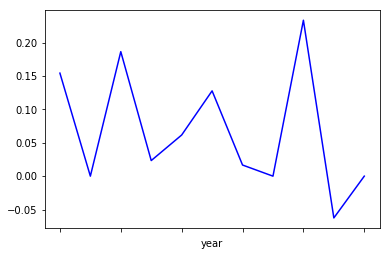

In [82]:
grouped_gm['polarity'].plot(kind='line', color='b')

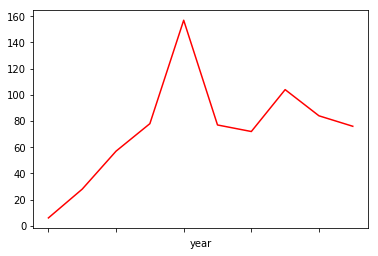

In [84]:
grouped_tesla['count'].plot(kind='line', color='r')

### _to do: bring the xticks back in for year_ 

### Show both plots on the same graph

In [85]:
combined_df = pandas.concat([grouped_gm, grouped_tesla], axis=1)

In [86]:
# need to rename our columns and index (note: this could be avoided through better use of the concat function above)
combined_df.columns=["GM_count", "GM_polarity", "Tesla_count", "Tesla_polarity"]
combined_df.index_name = "year"

In [87]:
combined_df = combined_df.fillna(0)

In [88]:
combined_df.head()

,GM_count,GM_polarity,Tesla_count,Tesla_polarity
2005,1,0.154167,0.0,0.000000
2006,1,0.000000,6.0,0.095694
2007,4,0.186326,28.0,0.093172
2008,5,0.023333,57.0,0.076862
2009,9,0.061574,78.0,0.101455


### Plot the combined dataframe

In [89]:
combined_df[["GM_count", "Tesla_count"]]

,GM_count,Tesla_count
2005,1,0.0
2006,1,6.0
2007,4,28.0
2008,5,57.0
2009,9,78.0
2010,10,157.0
2011,3,77.0
2012,1,72.0
2013,1,104.0
2014,2,84.0


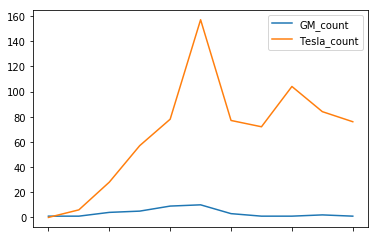

In [91]:
combined_df[["GM_count", "Tesla_count"]].plot()

## 2010 was a big year for Tesla, and GM [Hovig to fill in what happened in 2010 from the case]

In [92]:
combined_df[["GM_polarity","Tesla_polarity"]]

,GM_polarity,Tesla_polarity
2005,0.154167,0.000000
2006,0.000000,0.095694
2007,0.186326,0.093172
2008,0.023333,0.076862
2009,0.061574,0.101455
2010,0.127652,0.086953
2011,0.016667,0.075263
2012,0.000000,0.108582
2013,0.233333,0.065855
2014,-0.062500,0.112158


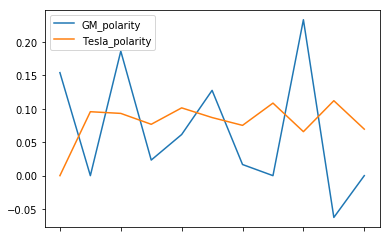

In [93]:
combined_df[["GM_polarity","Tesla_polarity"]].plot()

### 2005 might be misleading because there is only a single article for GM (it is positive); trying again with 2006-2015

In [94]:
combined_df[["GM_polarity","Tesla_polarity"]].iloc[1:]

,GM_polarity,Tesla_polarity
2006,0.000000,0.095694
2007,0.186326,0.093172
2008,0.023333,0.076862
2009,0.061574,0.101455
2010,0.127652,0.086953
2011,0.016667,0.075263
2012,0.000000,0.108582
2013,0.233333,0.065855
2014,-0.062500,0.112158
2015,0.000000,0.069585


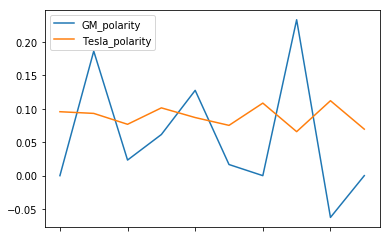

In [95]:
combined_df[["GM_polarity","Tesla_polarity"]].iloc[1:].plot()

#### 2010 seems like an important year, let's look closely at content before and after it

In [96]:
# going back to our original dataframes, organize them by their publication date (variable is called 'pub_date')
print (df_tesla.columns)

Index(['_id', 'abstract', 'blog', 'byline', 'document_type', 'headline',
       'keywords', 'multimedia', 'new_desk', 'print_page', 'pub_date', 'score',
       'section_name', 'snippet', 'source', 'type_of_material', 'uri',
       'web_url', 'word_count', 'year', 'polarity'],
      dtype='object')


In [97]:
# convert the pub_date string to pandas date object
df_tesla['pub_date'] = pandas.to_datetime(df_tesla['pub_date'])

In [98]:
# verify that this worked by looking at the first row
df_tesla['pub_date'].iloc[0]

Timestamp('2015-12-20 00:00:00')

In [99]:
# now do the same for df_gm
df_gm['pub_date'] = pandas.to_datetime(df_gm['pub_date'])

##### now, let's pull article titles from Tesla articles in 2009

In [100]:
df_tesla_2009 = df_tesla[(df_tesla['pub_date']>'2009-01-01') & (df_tesla['pub_date']<'2009-12-31') ]

In [101]:
print (len(df_tesla_2009))

78


In [102]:
df_tesla_2009_articleSnippets = df_tesla_2009['snippet']

In [103]:
print (df_tesla_2009_articleSnippets[:10])

570    After bankruptcies, bailouts and plunging sale...
571    Nothing seemed to herald the end of the intern...
572    A potential candidate for governor in Californ...
573    At the 2009 Los Angeles auto show, that fuzzy ...
574    Tesla Motors is close to a deal to build an el...
575    A reporter test-drove a Chevrolet Volt to see ...
576    California entrepreneurs find new uses for old...
577    As the whole automotive world seems to be raci...
578    Reva, which has been making stubby electric ca...
579    From the point of manufacture to the windshiel...
Name: snippet, dtype: object


In [106]:
# collapse all df_tesla_2009_articleSnippets into a single string
tesla_2009_articleSnippets_as_string= ' '.join(df_tesla_2009_articleSnippets)

In [107]:
# now, collapse into a TextBlob object, which we can analyze
tesla_2009_articleSnippets = TextBlob(tesla_2009_articleSnippets_as_string)

In [109]:
# we can access a list of all the words
tesla_2009_articleSnippets.words[:10]

WordList(['After', 'bankruptcies', 'bailouts', 'and', 'plunging', 'sales', 'perhaps', 'nothing', 'sums', 'up'])

In [111]:
# we can access the sentences
tesla_2009_articleSnippets.sentences[:10]

[Sentence("After bankruptcies, bailouts and plunging sales, perhaps nothing sums up the misery better than this: The United States is no longer the world’s top car market."),
 Sentence("Nothing seemed to herald the end of the internal combustion engine more than the ability of hybrid cars to leap suddenly to life without the slightest sound."),
 Sentence("Unfortunately, it turns out that the sweet silence of 21st-century technology has a serio... A potential candidate for governor in California, Steve Westly, is sitting back and watching for now."),
 Sentence("At the 2009 Los Angeles auto show, that fuzzy picture of a future we thought would never arrive is at last coming into focus."),
 Sentence("Tesla Motors is close to a deal to build an electric car factory at the site of a former N.A.S.A."),
 Sentence("manufacturing plant in Downey, Calif., a blue-collar city south of Los Angeles."),
 Sentence("A reporter test-drove a Chevrolet Volt to see how it performed after its electric power

In [117]:
# this is a dictionary with 'word': freq
tesla_2009_articleSnippets_word_counts = tesla_2009_articleSnippets.word_counts
# convert to a dataframe
df_tesla_2009_articleSnippets_word_counts = pandas.DataFrame.from_dict(tesla_2009_articleSnippets_word_counts,orient='index')

In [119]:
df_tesla_2009_articleSnippets_word_counts.head()

,0
entrepreneur,2
developed,1
packs,1
speedway,1
bought,1


In [125]:
# sort by values
df_tesla_2009_articleSnippets_word_counts = df_tesla_2009_articleSnippets_word_counts.sort_values(by=[0], ascending=False)

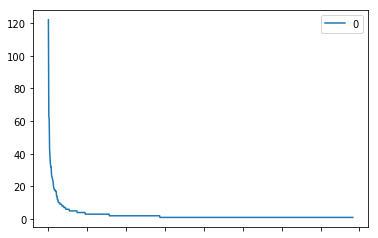

In [126]:
df_tesla_2009_articleSnippets_word_counts.plot()

In [129]:
df_tesla_2009_articleSnippets_word_counts.head()

,0
the,122
a,63
of,61
to,43
electric,38


In [150]:
# pronouns, articles, etc (from nltk stopwords.words('english'))
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [151]:
# remove common stopwords
stopwords_in_df = [word for word in stopwords if word in df_tesla_2009_articleSnippets_word_counts.index]
df_tesla_2009_articleSnippets_word_counts.drop(stopwords_in_df)

,0
electric,38
car,27
tesla,25
motors,17
new,14
cars,12
company,11
said,10
billion,10
one,9
